In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,ElasticNetCV
import requests
import io
import apache_log_parser
from pprint import pprint
import os

In [2]:
from typing import List

log_line_data = None
line_parser = apache_log_parser.make_parser("%h %l %u %t \"%r\" %>s %b")
with open(f"{os.getcwd()}/NASA_access_log_Jul95.log", mode='r') as f1:
    with open(f"{os.getcwd()}/NASA_access_log_Aug95.log", mode='r') as f2:
        log_line_data = [line_parser(line) for line in f1.readlines() + f2.readlines()]


In [3]:
df_log_line_data = pd.DataFrame([{"date": df_line["time_received_datetimeobj"], "count": 1} for df_line in log_line_data])
df_log_line_data

,date,count
0,1995-07-01 00:00:01,1
1,1995-07-01 00:00:06,1
2,1995-07-01 00:00:09,1
3,1995-07-01 00:00:11,1
4,1995-07-01 00:00:11,1
...,...,...
3461607,1995-08-31 23:59:49,1
3461608,1995-08-31 23:59:49,1
3461609,1995-08-31 23:59:52,1
3461610,1995-08-31 23:59:52,1


In [49]:
df_H = df_log_line_data.groupby(pd.Grouper(key="date", freq="H")).sum().reset_index()
df_H
    

,date,count
0,1995-07-01 00:00:00,3565
1,1995-07-01 01:00:00,3004
2,1995-07-01 02:00:00,2268
3,1995-07-01 03:00:00,1734
4,1995-07-01 04:00:00,1482
...,...,...
1483,1995-08-31 19:00:00,2946
1484,1995-08-31 20:00:00,2737
1485,1995-08-31 21:00:00,2463
1486,1995-08-31 22:00:00,2896


In [20]:
df_H_date = (pd.to_datetime(df_H["date"]).astype(int) / 10**9).array.reshape(-1, 1)
df_H_count = df_H["count"].array.reshape(-1, 1)

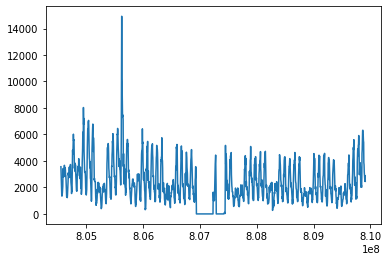

In [21]:
plt.plot(df_H_date, df_H_count)

In [7]:
def create_enet(x_train, y_train):
    return ElasticNet(alpha=1.0, l1_ratio=0.5).fit(x_train, y_train)

In [46]:
counter = 0
y_pred = pd.DataFrame([])
target_df_min_x_train = df_H_date[counter:counter+19, :]
target_df_H_y_train = df_H_count[counter:counter+19, :]
target_df_H_x_test = df_H_date[counter+20:counter+39, :]
target_df_H_enet = create_enet(target_df_H_x_train, target_df_H_y_train)
target_df_H_y_pred = target_df_H_enet.predict(target_df_H_x_test)
y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
y_pred

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/2992743820.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)


,0
0,3394.787667
1,3467.557838
2,3540.328009
3,3613.098179
4,3685.868350
5,3758.638521
6,3831.408692
7,3904.178862
8,3976.949033
9,4049.719204


In [64]:
def create_enet(alpha, l1_ratio, x_train, y_train):
    return ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(x_train, y_train)

def enet_loop(alpha, l1_ratio):
    counter = 0
    y_pred = pd.DataFrame([])
    for _index in range(int(df_H.size / 20)):
        try:
            target_df_H_x_train = df_H_date[counter:counter+19, :]
            target_df_H_y_train = df_H_count[counter:counter+19, :]
            target_df_H_x_test = df_H_date[counter+20:counter+39, :]
            target_df_H_enet = create_enet(alpha, l1_ratio, target_df_H_x_train, target_df_H_y_train)
            target_df_H_y_pred = target_df_H_enet.predict(target_df_H_x_test)
            y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
        except Exception as e:
            print(e)
        counter += 20
    return y_pred

In [48]:
y_pred

,0
0,3394.787667
1,3467.557838
2,3540.328009
3,3613.098179
4,3685.868350
...,...
1390,6773.659581
1391,6977.868348
1392,7182.077115
1393,7386.285882


/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append met

Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append met

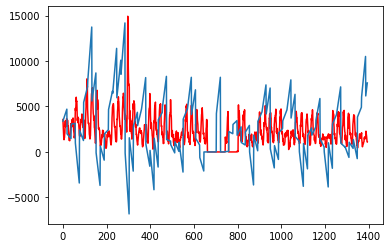

In [65]:
plt.plot(df_H_count[:1395], color='red')
plt.plot(enet_loop(1.0, 0.005))

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append met

Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append met

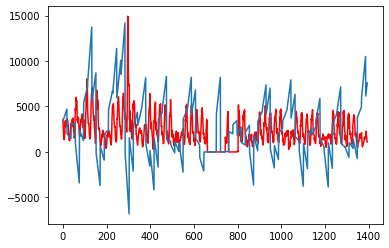

In [66]:
plt.plot(df_H_count[:1395], color='red')
plt.plot(enet_loop(10.0, 0.005))

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append met

Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append met

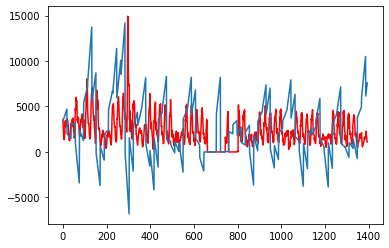

In [67]:
plt.plot(df_H_count[:1395], color='red')
plt.plot(enet_loop(1.0, 1.00))

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append met

Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append met

Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_H_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3666120513.py:14: FutureWarning: The frame.append met

Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1

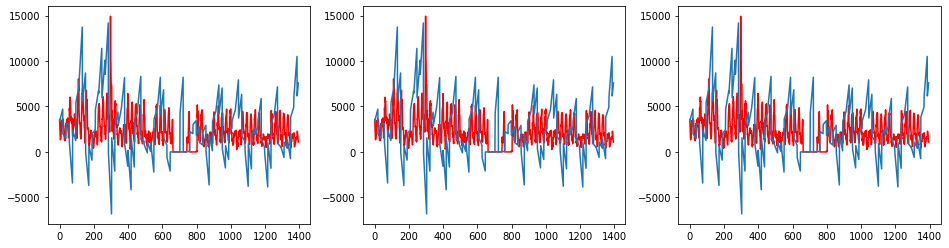

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for param, ax in zip([(1.0, 1.0), (1.0, 0.5), (1000, 0.2)], axes):
    ax.plot(df_H_count[:1395], color='red')
    ax.plot(enet_loop(param[0], param[1]))

In [70]:
df_min = df_log_line_data.groupby(pd.Grouper(key="date", freq="min")).sum().reset_index()
df_min
    

,date,count
0,1995-07-01 00:00:00,42
1,1995-07-01 00:01:00,61
2,1995-07-01 00:02:00,57
3,1995-07-01 00:03:00,71
4,1995-07-01 00:04:00,70
...,...,...
89275,1995-08-31 23:55:00,30
89276,1995-08-31 23:56:00,38
89277,1995-08-31 23:57:00,16
89278,1995-08-31 23:58:00,17


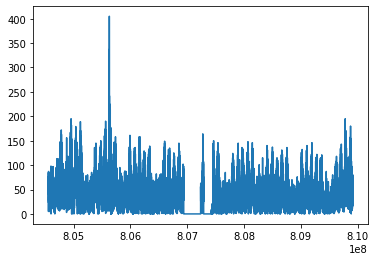

In [77]:
df_min_date = (pd.to_datetime(df_min["date"]).astype(int) / 10**9).array.reshape(-1, 1)
df_min_count = df_min["count"].array.reshape(-1, 1)
plt.plot(df_min_date, df_min_count)

In [78]:
def create_min_enet(alpha, l1_ratio, x_train, y_train):
    return ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(x_train, y_train)

def enet_min_loop(alpha, l1_ratio):
    counter = 0
    y_pred = pd.DataFrame([])
    for _index in range(int(df_min.size / 20)):
        try:
            target_df_min_x_train = df_min_date[counter:counter+19, :]
            target_df_min_y_train = df_min_count[counter:counter+19, :]
            target_df_min_x_test = df_min_date[counter+20:counter+39, :]
            target_df_min_enet = create_min_enet(alpha, l1_ratio, target_df_min_x_train, target_df_min_y_train)
            target_df_min_y_pred = target_df_min_enet.predict(target_df_min_x_test)
            y_pred = y_pred.append(pd.DataFrame(target_df_min_y_pred), ignore_index=True)
        except Exception as e:
            print(e)
        counter += 20
    return y_pred

In [80]:
df_min_y_pred = enet_min_loop(1.0, 0.5)

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3372204332.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_min_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3372204332.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_min_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3372204332.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_df_min_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/3372204332.py:14: FutureWarning: The frame.appe

Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1

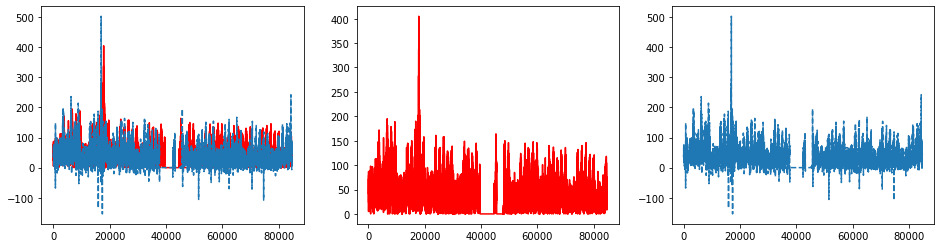

In [102]:
diff = df_min_count.size - int(df_min_count.size / 20)
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].plot(df_min_count[:diff], color='red')
axes[0].plot(df_min_y_pred, linestyle="dashed")
axes[1].plot(df_min_count[:diff], color='red')
axes[2].plot(df_min_y_pred, linestyle="dashed")

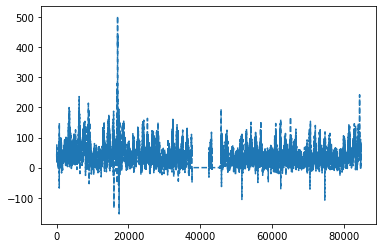

In [101]:
plt.plot(df_min_y_pred, linestyle="dashed")

In [98]:
int(df_min_count.size / 20)

4464

In [103]:
df_S = df_log_line_data.groupby(pd.Grouper(key="date", freq="S")).sum().reset_index()
df_S_date = (pd.to_datetime(df_S["date"]).astype(int) / 10**9).array.reshape(-1, 1)
df_S_count = df_S["count"].array.reshape(-1, 1)

def create_S_enet(alpha, l1_ratio, x_train, y_train):
    return ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(x_train, y_train)

def enet_S_loop(alpha, l1_ratio):
    counter = 0
    y_pred = pd.DataFrame([])
    for _index in range(int(df_S.size / 60)):
        try:
            target_df_S_x_train = df_S_date[counter:counter+59, :]
            target_df_S_y_train = df_S_count[counter:counter+59, :]
            target_df_S_x_test =  df_S_date[counter+60:counter+119, :]
            target_df_S_enet =    create_S_enet(alpha, l1_ratio, target_df_S_x_train, target_df_S_y_train)
            target_df_S_y_pred =  target_df_S_enet.predict(target_df_S_x_test)
            y_pred =              y_pred.append(pd.DataFrame(target_df_S_y_pred), ignore_index=True)
        except Exception as e:
            print(e)
        counter += 60
    return y_pred

In [110]:
y_S_pred = enet_S_loop(1.0, 0.05)

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/797065663.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred =              y_pred.append(pd.DataFrame(target_df_S_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/797065663.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred =              y_pred.append(pd.DataFrame(target_df_S_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/797065663.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred =              y_pred.append(pd.DataFrame(target_df_S_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_26276/797065663.py:18: 

In [111]:
y_S_pred

,0
0,0.495067
1,0.488074
2,0.481080
3,0.474087
4,0.467093
...,...
175579,-0.051130
175580,-0.061502
175581,-0.071874
175582,-0.082247


In [109]:
df_S_count.head

AttributeError: 'PandasArray' object has no attribute 'head'